<a href="https://colab.research.google.com/github/ichsanelf/Moekai-DeepLearningModel-CapstoneProject/blob/main/Copy_of_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
#!pip install tensorflowjs

In [2]:
#!pip install --upgrade pip
#!pip install tensorflow

In [3]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [4]:
#!pip install tensorflow==2.15.0

In [5]:
# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import ResNet50

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Collecting

In [6]:
# prompt: upload kaggle api key
'''
import os
# Upload kaggle.json
from google.colab import files
files.upload()

# Create the .kaggle directory and move the API key there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Check if the API key was uploaded successfully
!ls ~/.kaggle'''

'\nimport os\n# Upload kaggle.json\nfrom google.colab import files\nfiles.upload()\n\n# Create the .kaggle directory and move the API key there\n!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n!chmod 600 ~/.kaggle/kaggle.json\n\n# Check if the API key was uploaded successfully\n!ls ~/.kaggle'

In [12]:
# prompt: download a dataset from kaggle (https://www.kaggle.com/datasets/ichsanelf/private-dataset)
# Upload kaggle.json
from google.colab import files
files.upload()

# Create the .kaggle directory and move the API key there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d ichsanelf/private-dataset

# Unzip the dataset
!unzip private-dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Angry/344.jpg   
  inflating: Dataset/Angry/345.jpg   
  inflating: Dataset/Angry/346.jpg   
  inflating: Dataset/Angry/349.jpg   
  inflating: Dataset/Angry/35.jpg    
  inflating: Dataset/Angry/350.jpg   
  inflating: Dataset/Angry/353.jpg   
  inflating: Dataset/Angry/354.jpg   
  inflating: Dataset/Angry/355.jpg   
  inflating: Dataset/Angry/357.jpg   
  inflating: Dataset/Angry/358.jpg   
  inflating: Dataset/Angry/36.jpg    
  inflating: Dataset/Angry/360.jpg   
  inflating: Dataset/Angry/361.jpg   
  inflating: Dataset/Angry/363.jpg   
  inflating: Dataset/Angry/364.jpg   
  inflating: Dataset/Angry/365.jpg   
  inflating: Dataset/Angry/368.jpg   
  inflating: Dataset/Angry/36c8455fe8fa542426ae525cb71d77ed545c2caacc9680b81ea0e282~angry.jpg  
  inflating: Dataset/Angry/37.jpg    
  inflating: Dataset/Angry/370.jpg   
  inflating: Dataset/Angry/370aedd8724ac9883f71ce04ce90c8e50e144e5e3263899496db552e~angry.jpg

In [14]:
# Define the base path
path = "Dataset/"

# Initialize the dictionary
human_emotion = {}

# Iterate through each subfolder and collect images
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    if os.path.isdir(folder_path):  # Check if it is a directory
        images = []
        for filename in os.listdir(folder_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Filter image files
                images.append(os.path.join(folder_path, filename))
        human_emotion[folder] = images

# Print the dictionary to check the result
print(human_emotion.keys())

dict_keys(['Angry', 'Happy', 'Sad'])


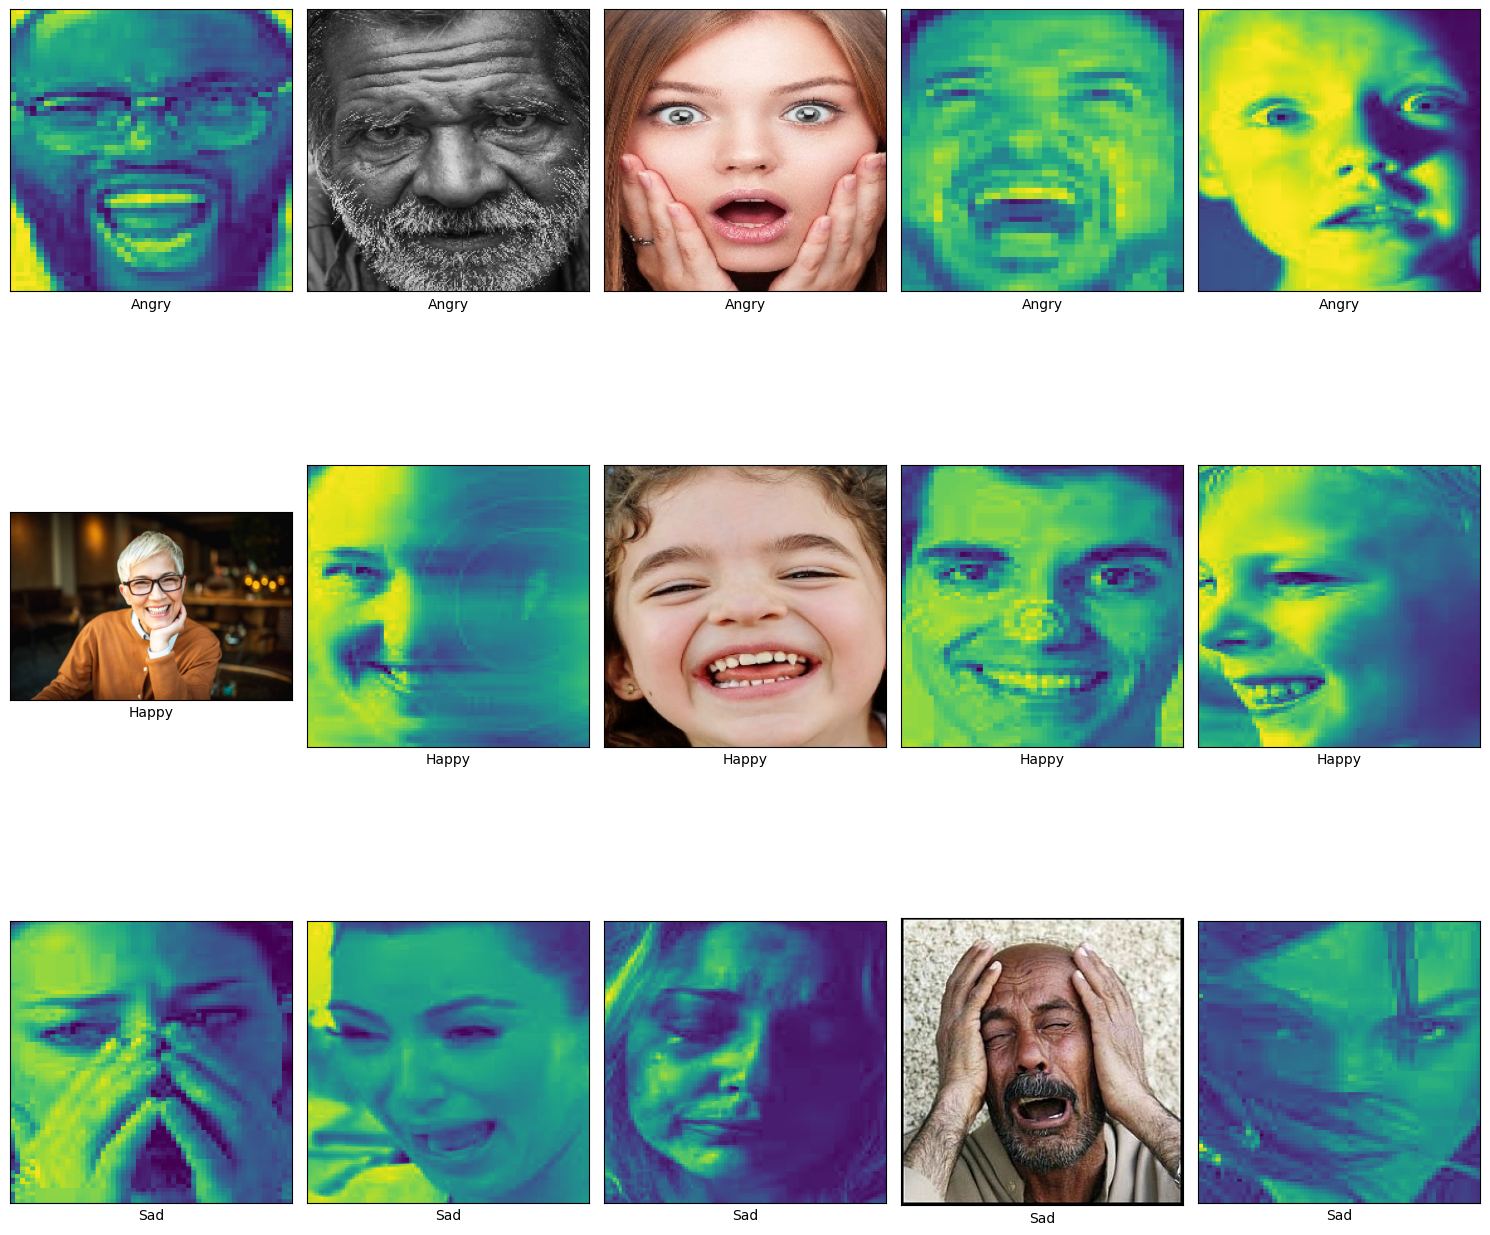

In [15]:
# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(human_emotion.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(human_emotion.keys()):
    images = np.random.choice(human_emotion[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = human_emotion[class_name][j]
        img = Image.open(img_path)  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

# Data Splitting

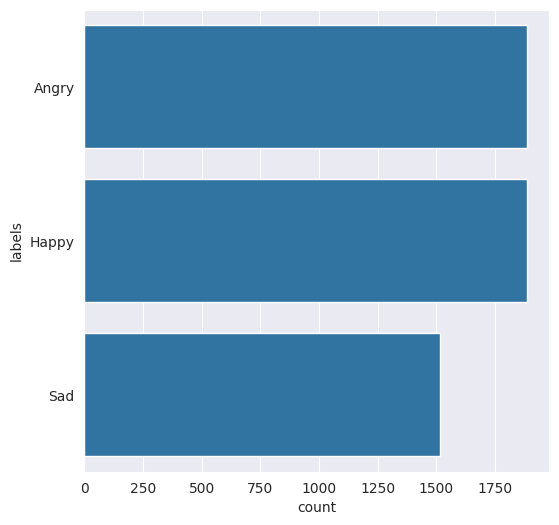

In [16]:
# Define source path
emotion_path = "Dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(emotion_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

images_df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = images_df['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [17]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= images_df['path']
y= images_df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [18]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [19]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 4231
test size 1058


In [20]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels
test   Angry      379
       Happy      390
       Sad        289
train  Angry     1508
       Happy     1496
       Sad       1227
dtype: int64 


                                                   path labels    set
1714  Dataset/Angry/images - 2020-11-06T005511.514_f...  Angry  train
2468  Dataset/Happy/images - 2020-11-06T193352.641_f...  Happy  train
4534  Dataset/Angry/images - 2020-11-06T003611.029_f...  Angry   test
5249                               Dataset/Angry/20.jpg  Angry   test
2527                              Dataset/Happy/537.jpg  Happy  train


In [21]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "Dataset/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [22]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

# Model

In [23]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

In [24]:
train_game = {}
for folder in os.listdir(TRAIN_DIR):
    folder_path = os.path.join(TRAIN_DIR, folder)
    if os.path.isdir(folder_path):
        train_game[folder] = len(os.listdir(folder_path))

print(f"Total number of games images in training :", train_game)

test_game = {}
for folder in os.listdir(TEST_DIR):
    folder_path = os.path.join(TEST_DIR, folder)
    if os.path.isdir(folder_path):
        test_game[folder] = len(os.listdir(folder_path))

print(f"Total number of games images in test :", test_game)

Total number of games images in training : {'Angry': 1508, 'Happy': 1496, 'Sad': 1227}
Total number of games images in test : {'Angry': 379, 'Happy': 390, 'Sad': 289}


In [25]:
datagen = ImageDataGenerator(
    rescale=1/255.,
    #zoom_range=0.2,
    #rotation_range=10,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #shear_range=0.2,
    #horizontal_flip=True,
    fill_mode='nearest',
    )
test_datagen = ImageDataGenerator(rescale=1 / 255.)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=16,
                                              target_size=(200, 200),
                                              color_mode="grayscale",
                                              class_mode='categorical',
                                              shuffle=True)

validation_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                        batch_size=16,
                                                        target_size=(200, 200),
                                                        color_mode="grayscale",
                                                        class_mode='categorical',
                                                        shuffle=False)


Found 4230 images belonging to 3 classes.
Found 1058 images belonging to 3 classes.


In [26]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

tf.keras.backend.clear_session()
# Load the ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Adjust for grayscale input
input_tensor = tf.keras.layers.Input(shape=(200, 200, 1))
x = tf.keras.layers.Conv2D(3, (3, 3), padding='same')(input_tensor)  # Convert to 3 channels
x = base_model(x)

n_classes=3
# Add custom top layers
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dense(256, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
x = layers.Dense(n_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=input_tensor, outputs=x)
optimize_lr = Nadam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimize_lr, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 200, 200, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,593,889 (90.00 MB)

 Trainable params: 23,540,769 (89.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [27]:
folder_weights = {}

# Calculate the total number of images across all folders
total_classes = len(train_game)
total_images = sum(train_game.values())

# Iterate through each folder and calculate the weight
for folder, count in train_game.items():
    weight = (1 / count) * total_images / total_classes
    folder_weights[folder] = weight

# Print the calculated weights
for folder, weight in folder_weights.items():
    print(f"Weight for {folder}: {weight}")

Weight for Angry: 0.9352343059239611
Weight for Happy: 0.9427361853832442
Weight for Sad: 1.1494159195870688


# Evaluasi

## Epoch process

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0000000001)

%time

# Fitting / training model
history_1 = model.fit(train_generator,
                        epochs=50,
                        batch_size=16,
                        validation_data=validation_generator,
                        class_weight = folder_weights,
                        callbacks=[early_stopping, reduce_lr]
                        )

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 7.39 µs


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 150s 294ms/step - accuracy: 0.6225 - loss: 0.8472 - val_accuracy: 0.3582 - val_loss: 2.8811 - learning_rate: 1.0000e-04
Epoch 2/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 48s 180ms/step - accuracy: 0.8913 - loss: 0.2980 - val_accuracy: 0.2732 - val_loss: 3.1351 - learning_rate: 1.0000e-04
Epoch 3/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 47s 178ms/step - accuracy: 0.9539 - loss: 0.1461 - val_accuracy: 0.2732 - val_loss: 2.5567 - learning_rate: 1.0000e-04
Epoch 4/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 48s 179ms/step - accuracy: 0.9683 - loss: 0.0959 - val_accuracy: 0.3072 - val_loss: 1.7626 - learning_rate: 1.0000e-04
Epoch 5/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 84s 187ms/step - accuracy: 0.9716 - loss: 0.0850 - val_accuracy: 0.7344 - val_loss: 0.7823 - learning_rate: 1.0000e-04
Epoch 6/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 47s 176ms/step - accuracy: 0.9790 - loss: 0.0676 - val_accuracy: 0.7457 - val_loss: 1.0092 - learning_rate: 1.0000e-04
Epoch 7/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 84s 1

## Val acc & loss Plot

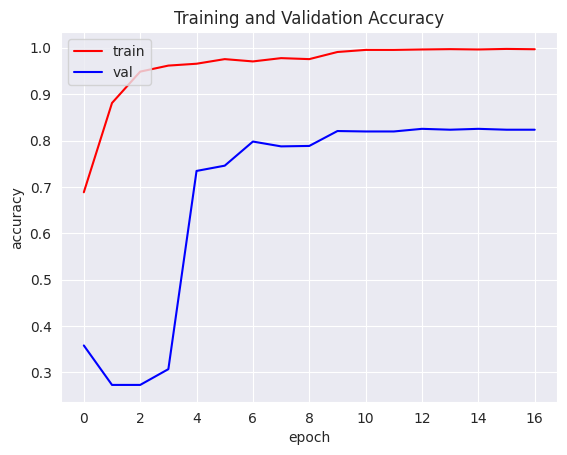

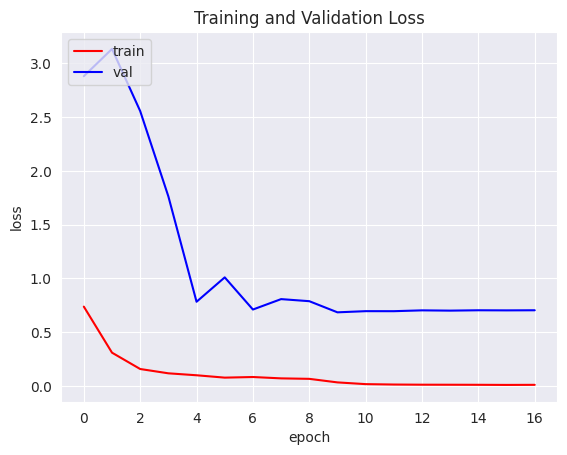

In [29]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

## Confusion Matrix



              precision    recall  f1-score   support

       Angry     0.8247    0.7942    0.8091       379
       Happy     0.8821    0.8821    0.8821       390
         Sad     0.7360    0.7716    0.7534       289

    accuracy                         0.8204      1058
   macro avg     0.8142    0.8160    0.8149      1058
weighted avg     0.8216    0.8204    0.8208      1058



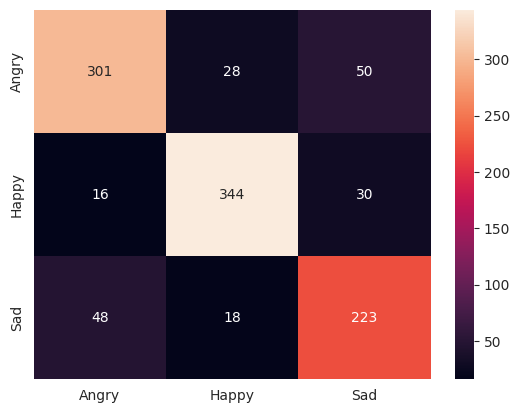

In [30]:
validation_generator.reset()

preds_1 = model.predict(validation_generator,verbose=0)

predicted_labels = np.argmax(preds_1, axis=1)

cm = pd.DataFrame(data=confusion_matrix(validation_generator.classes, predicted_labels),
                  index=train_generator.class_indices,
                  columns=train_generator.class_indices)

sns.heatmap(cm,annot=True,fmt="d")

print("\n")
print(classification_report(y_true=validation_generator.classes,
                            y_pred=predicted_labels,
                            target_names = train_generator.class_indices,
                            digits=4))